In [1]:
import numpy as np
import pandas as pd
import librosa
from os import listdir
from librosa import display
import matplotlib.pyplot as plt
import pickle
from scipy import signal
from scipy import stats
from scipy import fftpack
import timeit

In [2]:
#Read in the paths to all the audio files. audio_paths is a dictionary.
audio_paths = pickle.load(open( "all_audio_paths", "rb" ) )

In [3]:
#This is a dataframe with metadata of each individual.
df = pd.read_csv('clean_meta_data')

In [4]:
df.head()

,Unnamed: 0,VoxCeleb2 ID,VGGFace2 ID,Gender,Set
0,0,id00012,n000012,m,dev
1,1,id00015,n000015,m,dev
2,2,id00016,n000016,m,dev
3,3,id00017,n000017,m,test
4,4,id00018,n000018,m,dev


In [36]:
#Determining where the index is for the ID of celeb
index = df.iloc[df[df['VoxCeleb2 ID'] == 'id04789'].index]
index, df['VoxCeleb2 ID'][3204]

(      Unnamed: 0 VoxCeleb2 ID VGGFace2 ID Gender  Set
 3203        3203      id04789    n004788       m  dev, 'id04800')

In [56]:
#Loading in two audio files for testing purposes
y, sr = librosa.load(audio_paths['id04239'][0], duration = 4.0, sr = 16384)
y_f, sr = librosa.load(audio_paths['id04175'][4], duration = 4.0, sr = 16384)

KeyError: 'id04239'

In [256]:
keys_list = list(audio_paths.keys())

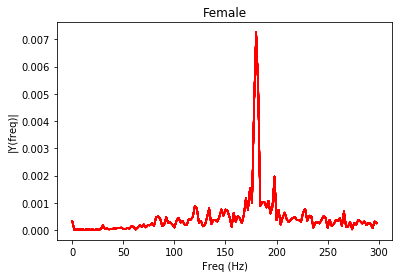

In [287]:
graph_individual_fft('id01760')

In [226]:
#Graphing an individual's fft plot.
def graph_individual_fft(key):
    gender = df.iloc[df[df['VoxCeleb2 ID'] == key].index]['Gender'].values[0]
    for value in audio_paths[key]:
        if gender == 'm':
            plot_fft_m(value, 4, 16384)
        else:
            plot_fft_f(value, 4, 16384)

In [399]:
def plot_fft_m(path, length, sr):
    #Path: path to the file
    #length: length of audio file to be sampled
    #sr:sampling rate
    y, sr = librosa.load(path, duration = length, sr = sr)
    n = len(y)//2 # length of the signal
    half_second = sr//2
    y=y[range(n-half_second, n+half_second)]
    n = len(y)
    k = np.arange(n)
    T = n/sr
    frq = k/T # two sides frequency range
    frq = frq[range(75, 260)] # one side frequency range

    Ymale = fftpack.fft(y)/n # fft computing and normalization
    Ymale = Ymale[range(75, 260)]

#     plt.figure(figsize=(4,4))
    plt.plot(frq,abs(Ymale),'b') # plotting the spectrum
    plt.title('Male')
    plt.xlabel('Freq (Hz)')
    plt.ylabel('|Y(freq)|')

In [419]:
def plot_fft_f(path, length, sr):
    #Path: path to the file
    #length: length of audio file to be sampled
    #sr:sampling rate
    y, sr = librosa.load(path, duration = length, sr = sr)
    n = len(y)//2 # length of the signal
    half_second = sr//2
    y=y[range(n-half_second, n+half_second)]
    n = len(y)
    k = np.arange(n)
    T = n/sr
    frq = k/T # two sides frequency range
    frq = frq[range(70,260)] # one side frequency range

    Yfemale = fftpack.fft(y) # fft computing and normalization
    Yfemale = Yfemale[range(70,260)]

#     plt.figure(figsize=(4,4))
    plt.plot(frq,abs(Yfemale),'r') # plotting the spectrum
    plt.title('Female')
    plt.xlabel('Freq (Hz)')
    plt.ylabel('|Y(freq)|')
    print(len(Yfemale))

In [3]:
#Takes audio path, length, and sampling rate and returns the absolute value of the fourier transformation. This
#gives you the magnitude/power of each frequency in the audio.
import librosa
from scipy import fftpack

def fft(path, length, sr):
    y, sr = librosa.load(path, duration = length, sr = sr)
    n = len(y)//2 # length of the signal
    half_second = sr//2
    y=y[range(n-half_second, n+half_second)]
    y_fft = fftpack.fft(y) # fft computing
    y_fft = y_fft[range(70,260)] # Keeps the values for the frequency from 70-260 (human speech)
    return abs(y_fft)

In [41]:
#Goes through each audio file path and creates a dataframe with the fft and gender data.
count = 0
for key in df['VoxCeleb2 ID'][]:
    if key in audio_paths.keys():
        count+=1
        pickle_df = pd.DataFrame()
        gender = df.iloc[df[df['VoxCeleb2 ID'] == key].index]['Gender'].values[0]
        for paths in audio_paths[key]:
            temp_df = pd.DataFrame(fft(paths, 4, 16384)).T
            temp_df['Gender'] = gender
            temp_df['ID'] = key
            pickle_df = pickle_df.append(temp_df)
        pickle.dump(pickle_df, open("/home/ubuntu/Pickles/"+str(key), "wb" ) )           
        print(key, count)


id04802 2
id04803 3
id04814 4
id04818 5
id04820 6
id04821 7
id04822 8
id04823 9
id04825 10
id04826 11
id04827 12
id04835 13
id04836 14
id04837 15
id04838 16
id04839 17
id04841 18
id04842 19
id04844 20
id04845 21
id04846 22
id04847 23
id04851 24
id04852 25
id04854 26
id04857 27
id04866 28
id04869 29
id04872 30
id04873 31
id04875 32
id04876 33
id04877 34
id04884 35
id04885 36
id04886 37
id04887 38
id04888 39
id04889 40
id04894 41
id04896 42
id04897 43
id04898 44
id04899 45
id04900 46
id04901 47
id04903 48
id04906 49
id04907 50
id04908 51
id04909 52
id04911 53
id04914 54
id04915 55
id04917 56
id04918 57
id04926 58
id04928 59
id04930 60
id04933 61
id04934 62
id04935 63
id04939 64
id04940 65
id04941 66
id04945 67
id04946 68
id04948 69
id04951 70
id04953 71
id04956 72
id04957 73
id04958 74
id04959 75
id04961 76
id04962 77
id04963 78
id04964 79
id04967 80
id04969 81
id04970 82
id04971 83
id04972 84
id04973 85
id04974 86
id04976 87
id04977 88
id04978 89
id04979 90
id04980 91
id04981 92
id04982

id06135 697
id06138 698
id06139 699
id06142 700
id06143 701
id06145 702
id06146 703
id06148 704
id06155 705
id06156 706
id06159 707
id06161 708
id06162 709
id06163 710
id06164 711
id06165 712
id06166 713
id06168 714
id06173 715
id06174 716
id06176 717
id06178 718
id06183 719
id06184 720
id06185 721
id06188 722
id06191 723
id06194 724
id06196 725
id06199 726
id06202 727
id06207 728
id06211 729
id06212 730
id06213 731
id06214 732
id06215 733
id06216 734
id06217 735
id06218 736
id06221 737
id06225 738
id06226 739
id06227 740
id06228 741
id06229 742
id06232 743
id06233 744
id06234 745
id06235 746
id06236 747
id06238 748
id06239 749
id06242 750
id06244 751
id06245 752
id06246 753
id06247 754
id06248 755
id06249 756
id06250 757
id06251 758
id06254 759
id06255 760
id06256 761
id06258 762
id06261 763
id06262 764
id06263 765
id06264 766
id06265 767
id06268 768
id06269 769
id06270 770
id06275 771
id06278 772
id06280 773
id06288 774
id06289 775
id06293 776
id06297 777
id06298 778
id06301 779
id06

id07368 1353
id07369 1354
id07370 1355
id07371 1356
id07374 1357
id07375 1358
id07376 1359
id07377 1360
id07383 1361
id07384 1362
id07385 1363
id07389 1364
id07392 1365
id07393 1366
id07395 1367
id07397 1368
id07398 1369
id07400 1370
id07401 1371
id07402 1372
id07404 1373
id07405 1374
id07407 1375
id07409 1376
id07411 1377
id07416 1378
id07417 1379
id07418 1380
id07419 1381
id07421 1382
id07422 1383
id07423 1384
id07428 1385
id07429 1386
id07430 1387
id07431 1388
id07432 1389
id07434 1390
id07437 1391
id07438 1392
id07441 1393
id07442 1394
id07445 1395
id07446 1396
id07447 1397
id07448 1398
id07452 1399
id07453 1400
id07454 1401
id07457 1402
id07459 1403
id07460 1404
id07461 1405
id07462 1406
id07463 1407
id07465 1408
id07466 1409
id07468 1410
id07469 1411
id07470 1412
id07471 1413
id07473 1414
id07477 1415
id07478 1416
id07483 1417
id07484 1418
id07489 1419
id07491 1420
id07492 1421
id07493 1422
id07495 1423
id07497 1424
id07498 1425
id07500 1426
id07506 1427
id07507 1428
id07508 1429

id08551 1984
id08553 1985
id08554 1986
id08555 1987
id08556 1988
id08563 1989
id08564 1990
id08565 1991
id08566 1992
id08567 1993
id08568 1994
id08569 1995
id08570 1996
id08573 1997
id08574 1998
id08577 1999
id08578 2000
id08581 2001
id08583 2002
id08584 2003
id08585 2004
id08586 2005
id08587 2006
id08588 2007
id08589 2008
id08590 2009
id08592 2010
id08593 2011
id08595 2012
id08597 2013
id08598 2014
id08599 2015
id08601 2016
id08603 2017
id08604 2018
id08605 2019
id08606 2020
id08607 2021
id08608 2022
id08609 2023
id08611 2024
id08612 2025
id08613 2026
id08615 2027
id08616 2028
id08617 2029
id08622 2030
id08623 2031
id08624 2032
id08625 2033
id08626 2034
id08627 2035
id08628 2036
id08633 2037
id08634 2038
id08635 2039
id08637 2040
id08638 2041
id08639 2042
id08640 2043
id08641 2044
id08642 2045
id08643 2046
id08645 2047
id08647 2048
id08649 2049
id08650 2050
id08651 2051
id08652 2052
id08653 2053
id08655 2054
id08657 2055
id08659 2056
id08660 2057
id08665 2058
id08666 2059
id08667 2060

In [ ]:
#Same as above but I was running short on time and wanted to gather more audio from female speakers so I altered
#the for loop to capture all female and only some male files starting at the 3204 index.
count = 0
for key in df['VoxCeleb2 ID'][3204:]:
    if key in audio_paths.keys():
        count+=1
        pickle_df = pd.DataFrame()
        gender = df.iloc[df[df['VoxCeleb2 ID'] == key].index]['Gender'].values[0]
        if gender == 'f':
            for paths in audio_paths[key]:
                temp_df = pd.DataFrame(fft(paths, 4, 16384)).T
                temp_df['Gender'] = gender
                temp_df['ID'] = key
                pickle_df = pickle_df.append(temp_df)
            pickle.dump(pickle_df, open("/home/ubuntu/Pickles/"+str(key), "wb" ) )
        else:
            for paths in audio_paths[key][:10]:
                temp_df = pd.DataFrame(fft(paths, 4, 16384)).T
                temp_df['Gender'] = gender
                temp_df['ID'] = key
                pickle_df = pickle_df.append(temp_df)
            pickle.dump(pickle_df, open("/home/ubuntu/Pickles/"+str(key), "wb" ) )            
        print(key, count)

In [6]:
#Testing out my model on my classmate, Chris
pd.DataFrame(fft('/home/ubuntu/Chris.m4a', 4, 16384)).T.to_csv('Chris_fft')

In [431]:
#Making sure that my FFT was working well.
pd.DataFrame(fft(audio_paths['id08737'][1], 4, 16384)).T

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,20.707733,6.178031,14.081742,21.126434,8.257714,9.262204,10.783727,7.731854,7.640745,1.047333,...,16.525494,18.050911,19.997814,7.969493,24.576046,17.988745,13.053467,14.825317,25.705126,30.436588


In [16]:
#Extracting additional features from FFT.
def extract_features(path):
    y, sr = librosa.load(path, sr=None, duration=4.0)
    fourier = librosa.core.stft(y)
    magnitude, phase = librosa.magphase(fourier)
#     components, activations = librosa.decompose.decompose(magnitude, n_components=8, sort=True)
    
    #Calculating spectral sentroid
    sc = librosa.feature.spectral_centroid(y, sr=sr).mean()
    sc_std = librosa.feature.spectral_centroid(y, sr=sr).std()
    
    #Calculating skew, kurtosis, and rmse
    skew = stats.skew(y)
    kurtosis = stats.kurtosis(y)
    rmse = librosa.feature.rmse(S=magnitude).mean()
    rmse_std = librosa.feature.rmse(S=magnitude).std()
    #Calculating mean spectral roll off
    sr = librosa.feature.spectral_rolloff(y).mean()
    
    #Calculating Zero-Crossing-Rate
    zcr = librosa.feature.zero_crossing_rate(y).mean()
    zcr_std = librosa.feature.zero_crossing_rate(y).std()
    
    #Calculating tempo
    tempo = librosa.beat.tempo(y, sr=sr)[0]
    
    #Finding first 3 mel cepstral coefficients
    coefficients = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = 3)
    mfcc_1 = coefficients[0].mean()
    mfcc_2 = coefficients[1].mean()
    mfcc_3 = coefficients[2].mean()
    
    #Creating a dictionary of values
    features = dict()
    features['Spectral_Centroid'] = [sc]
    features['Spectral_Centroid_std'] = [sc_std]
    features['Skew'] = [skew]
    features['Kurtosis'] = [kurtosis]
    features['RMSE'] = [rmse]
    features['RMSE_std'] = [rmse_std]
    features['Spectral_rolloff'] = [sr]
    features['Tempo'] = [tempo]
    features['mfcc_1'] = [mfcc_1]
    features['mfcc_2'] = [mfcc_2]
    features['mfcc_3'] = [mfcc_3]
    features['Zero_Crossing_Rate'] = [zcr]
    features['Zero_Crossing_std'] = [zcr_std]
    
    return features
      

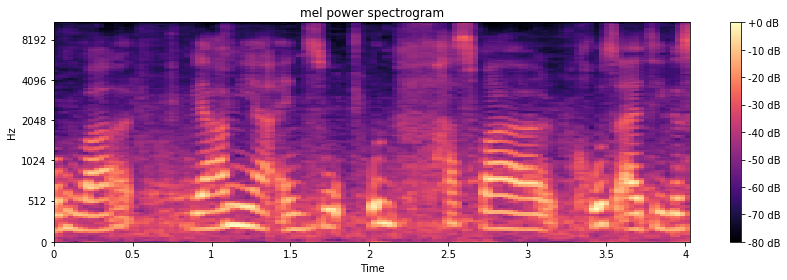

In [198]:
#Graphing a sample mel-spectrogram
log_S = librosa.power_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()